<a href="https://colab.research.google.com/github/amanmehra-23/TSA-Project/blob/main/Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install ta
#!pip install statsmodels
#!pip install plotly
#!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import ta
import plotly.express as px
import statsmodels.tsa.stattools as ts
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

In [3]:
df_daily =pd.read_csv("/content/EURUSDdaily.csv")

In [4]:
df_daily.head()

,1971.01.04,00:00,0.53690,0.53690.1,0.53690.2,0.53690.3,1
0,1971.01.05,00:00,0.5366,0.5366,0.5366,0.5366,1
1,1971.01.06,00:00,0.5365,0.5365,0.5365,0.5365,1
2,1971.01.07,00:00,0.5368,0.5368,0.5368,0.5368,1
3,1971.01.08,00:00,0.5371,0.5371,0.5371,0.5371,1
4,1971.01.11,00:00,0.5371,0.5371,0.5371,0.5371,1


In [5]:
headers = ['Date','Time','Open', 'High', 'Low', 'Close', 'Volume']
df_daily.columns = headers
df_hourly.columns = headers

In [6]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12492 entries, 0 to 12491
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12492 non-null  object 
 1   Time    12492 non-null  object 
 2   Open    12492 non-null  float64
 3   High    12492 non-null  float64
 4   Low     12492 non-null  float64
 5   Close   12492 non-null  float64
 6   Volume  12492 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 683.3+ KB


In [7]:
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

In [8]:
df_hourly.head()

,Date,Time,Open,High,Low,Close,Volume
0,2010.05.04,00:00,1.31884,1.31981,1.31853,1.31980,750
1,2010.05.04,01:00,1.31982,1.32004,1.31885,1.31942,626
2,2010.05.04,02:00,1.31947,1.32120,1.31915,1.32083,954
3,2010.05.04,03:00,1.32084,1.32131,1.31970,1.32073,896
4,2010.05.04,04:00,1.32076,1.32122,1.31928,1.32013,893


## Date vs Closing Price


In [9]:
fig = px.line(df_daily, x='Date', y=['Close'])
fig.show()

##ARIMA MODEL Approach

Upon visual inspection we conclude the data is not stationary

In [10]:
def adf_test(timeseries):
    """
    Performs an Augmented Dickey-Fuller test and prints the results.

    Args:
        timeseries (pd.Series): The time series data to test.

    Returns:
        None
    """
    print ('Results of Dickey-Fuller Test:')
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [11]:
adf_test(df_daily['Close'])

Results of Dickey-Fuller Test:
Test Statistic                    -2.467183
p-value                            0.123665
#Lags Used                         0.000000
Number of Observations Used    12491.000000
Critical Value (1%)               -3.430874
Critical Value (5%)               -2.861771
Critical Value (10%)              -2.566893
dtype: float64


Seeing the reulst of the Augemnted Dickey Fuller test we can conclude that the Data is not stationary.

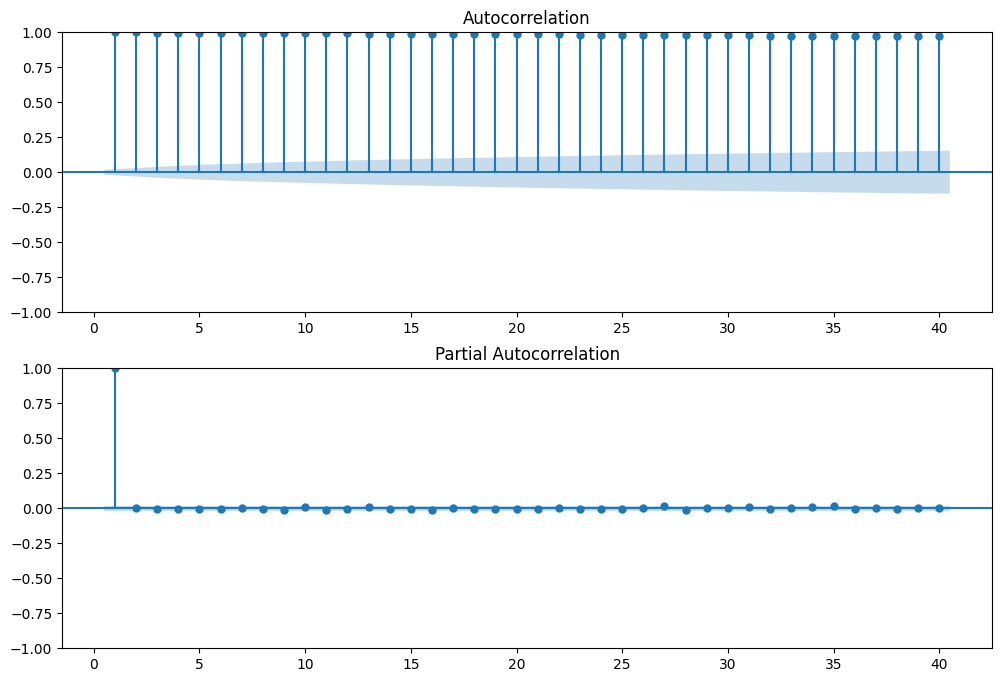

In [12]:
#ACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sgt.plot_acf(df_daily['Close'], lags = 40, zero = False, ax=ax1)

#PACF
ax2 = fig.add_subplot(212)
fig = sgt.plot_pacf(df_daily['Close'], lags = 40, zero = False, ax=ax2)
plt.show()

Here we can see that all values of the acf plot are showing significant effect

In [13]:
# Adding SMA
df_daily['SMA_20'] = ta.trend.SMAIndicator(df_daily['Close'], window=20).sma_indicator()

# Adding EMA
df_daily['EMA_20'] = ta.trend.EMAIndicator(df_daily['Close'], window=20).ema_indicator()

# Adding RSI
df_daily['RSI'] = ta.momentum.RSIIndicator(df_daily['Close'], window=14).rsi()

# Adding MACD
macd = ta.trend.MACD(df_daily['Close'])
df_daily['MACD'] = macd.macd()
df_daily['MACD_signal'] = macd.macd_signal()
df_daily['MACD_hist'] = macd.macd_diff()

# Adding Bollinger Bands
bb = ta.volatility.BollingerBands(df_daily['Close'], window=20, window_dev=2)
df_daily['BB_upper'] = bb.bollinger_hband()
df_daily['BB_middle'] = bb.bollinger_mavg()
df_daily['BB_lower'] = bb.bollinger_lband()

# Adding ATR
df_daily['ATR'] = ta.volatility.AverageTrueRange(df_daily['High'], df_daily['Low'], df_daily['Close'], window=14).average_true_range()

# Adding Stochastic Oscillator (Stoch)
stoch = ta.momentum.StochasticOscillator(df_daily['High'], df_daily['Low'], df_daily['Close'], window=14, smooth_window=3)
df_daily['STOCH_k'] = stoch.stoch()
df_daily['STOCH_d'] = stoch.stoch_signal()

In [14]:
df_daily.head()

,Date,Time,Open,High,Low,Close,Volume,SMA_20,EMA_20,RSI,MACD,MACD_signal,MACD_hist,BB_upper,BB_middle,BB_lower,ATR,STOCH_k,STOCH_d
0,1971-01-05,00:00,0.5366,0.5366,0.5366,0.5366,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,1971-01-06,00:00,0.5365,0.5365,0.5365,0.5365,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,1971-01-07,00:00,0.5368,0.5368,0.5368,0.5368,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,1971-01-08,00:00,0.5371,0.5371,0.5371,0.5371,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,1971-01-11,00:00,0.5371,0.5371,0.5371,0.5371,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [15]:
df_daily.dropna(inplace=True)

In [16]:
df_daily.tail()

,Date,Time,Open,High,Low,Close,Volume,SMA_20,EMA_20,RSI,MACD,MACD_signal,MACD_hist,BB_upper,BB_middle,BB_lower,ATR,STOCH_k,STOCH_d
12487,2020-10-14,00:00,1.17452,1.17712,1.17195,1.17452,41998,1.174434,1.176192,48.139412,-0.000248,-0.000719,0.000471,1.186215,1.174434,1.162653,0.007163,60.953254,71.066300
12488,2020-10-15,00:00,1.17452,1.17576,1.16882,1.17073,46911,1.173733,1.175672,44.521247,-0.000652,-0.000705,0.000053,1.184607,1.173733,1.162858,0.007147,42.823967,54.818499
12489,2020-10-16,00:00,1.17073,1.17460,1.16939,1.17153,41413,1.173103,1.175277,45.453197,-0.000897,-0.000744,-0.000154,1.182901,1.173103,1.163304,0.007008,32.094395,45.290539
12490,2020-10-19,00:00,1.17181,1.17929,1.17023,1.17656,50490,1.173077,1.175399,51.023928,-0.000678,-0.000731,0.000052,1.182837,1.173077,1.163317,0.007155,55.555556,43.491306
12491,2020-10-20,00:00,1.17660,1.17700,1.17652,1.17694,331,1.173385,1.175546,51.427512,-0.000468,-0.000678,0.000210,1.183224,1.173385,1.163547,0.006678,57.102672,48.250874


In [17]:
exog_columns = ['SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'BB_upper', 'BB_middle', 'BB_lower', 'ATR', 'STOCH_k', 'STOCH_d']

# Define your endogenous variable (e.g., the target variable - Close prices)
y = df_daily['Close']

# Define exogenous variables (technical indicators)
X = df_daily[exog_columns]

In [18]:
# Split the dataset (95% train, 5% test)
train_size = int(len(df_daily) * 0.95)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

In [19]:
# Use pmdarima's auto_arima to find the best (p,d,q) for ARIMAX model
# Allow auto_arima to handle differencing if needed (d parameter)
arimax_model = auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                          max_p=5, max_q=5, m=1, seasonal=False,
                          d=None,  # Allow it to automatically determine differencing
                          trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83421.589, Time=10.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83424.925, Time=7.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83423.550, Time=6.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-83423.546, Time=18.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83426.273, Time=0.85 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 44.407 seconds


In [20]:
print(arimax_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                11836
Model:               SARIMAX(0, 1, 0)   Log Likelihood               41714.136
Date:                Sun, 13 Oct 2024   AIC                         -83426.273
Time:                        12:46:53   BIC                         -83418.894
Sample:                             0   HQIC                        -83423.796
                              - 11836                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.082e-05   3.75e-07    135.522      0.000    5.01e-05    5.16e-05
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):              8725.11
Prob(Q):                              0.43   Pr

In [21]:
arimax_model.fit(y_train, exogenous=X_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [22]:
# Make predictions on the test set
y_pred = arimax_model.predict(n_periods=len(y_test), exogenous=X_test)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [23]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0019572069565007995


In [24]:
df_combined = pd.DataFrame({
    'Date': df_daily['Date'],
    'Train': y_train,
    'Test': y_test,
    'Predicted': y_pred
})

# Plot using Plotly Express
fig = px.line(df_combined, x='Date', y=['Train', 'Test', 'Predicted'],
              labels={'Train': 'Training Data', 'Test': 'Testing Data', 'Predicted': 'Predicted Data'},
              title='Train, Test and Predicted Closing Prices')

# Show the plot
fig.show()

##LSTM Approach

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objs as go

In [26]:
df_daily_dates =df_daily.copy()
df_daily = df_daily.drop(['Date', 'Time'], axis=1)

In [27]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_daily)

In [28]:
X = scaled_data[:, df_daily.columns != 'Close']  # All columns except 'Close' (features)
y = scaled_data[:, df_daily.columns.get_loc('Close')]  # 'Close' price column as target

In [29]:
def create_sequences(X, y, time_steps=5):  # 5-year look-back period
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)



In [30]:
# Set the time_steps to 5 (5 years look-back period)
time_steps = 5
X_seq, y_seq = create_sequences(X, y, time_steps)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [32]:
model = Sequential()

# Add LSTM layers with dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (regression, so no activation function)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 50)               │          13,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,651 (131.45 KB)

 Trainable params: 33,651 (131.45 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0282 - val_loss: 8.1759e-04
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0023 - val_loss: 3.3186e-04
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0019 - val_loss: 2.7304e-04
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0016 - val_loss: 3.8808e-04
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015 - val_loss: 2.2708e-04
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0014 - val_loss: 1.0229e-04
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0012 - val_loss: 8.3040e-04
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - val_loss: 1.2861e-04
Epoch 9/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - val_loss: 1.9160e-04
Epoch 10/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 9.0524e-04 - val_loss: 9.0409e-05
Epoch 11/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.7093e-04 - val_loss: 4.0141e-

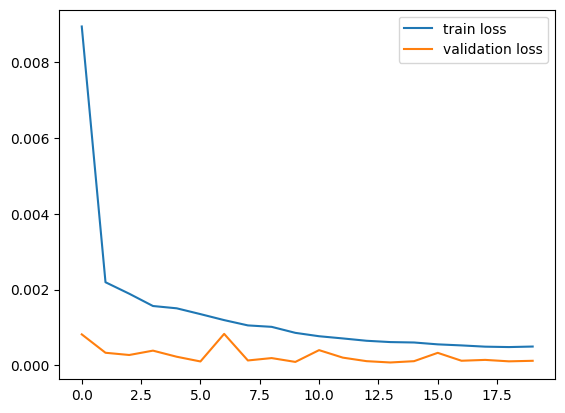

In [34]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [35]:
predicted_price = model.predict(X_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [36]:
# Extract the 'Close' column for scaling separately
close_scaler = MinMaxScaler()

# Fit the scaler on the 'Close' price column only
close_scaled = close_scaler.fit_transform(df_daily[['Close']])


In [46]:
actual_price_rescaled_train = close_scaler.inverse_transform(y_train.reshape(-1, 1))

# Make predictions (assuming 'predicted_price' is already computed by the model)
predicted_price_rescaled = close_scaler.inverse_transform(predicted_price)

# Rescale the actual closing prices
actual_price_rescaled_test = close_scaler.inverse_transform(y_test.reshape(-1, 1))

In [38]:
mse = mean_squared_error(actual_price_rescaled, predicted_price_rescaled)
mae = mean_absolute_error(actual_price_rescaled, predicted_price_rescaled)

print(f'MSE: {mse}')
print(f'MAE: {mae}')


MSE: 0.0001355057338598787
MAE: 0.009399136773197108


In [40]:
date_data = df_daily_dates['Date']

In [47]:
train_df = pd.DataFrame({
    'Date': date_data[:len(y_train)],
    'Close_Train': actual_price_rescaled_train.flatten()
})

test_df = pd.DataFrame({
    'Date': date_data[len(y_train):len(y_train) + len(y_test)],
    'Close_Test': actual_price_rescaled_test.flatten(),
    'Predicted_Close': predicted_price_rescaled.flatten()
})

# Create Plotly traces
trace_train = go.Scatter(x=train_df['Date'], y=train_df['Close_Train'], mode='lines', name='Y_train')
trace_test = go.Scatter(x=test_df['Date'], y=test_df['Close_Test'], mode='lines', name='Y_test', line=dict(color='blue'))
trace_pred = go.Scatter(x=test_df['Date'], y=test_df['Predicted_Close'], mode='lines', name='Y_pred', line=dict(color='red', dash='dash'))

# Layout configuration
layout = go.Layout(
    title="Y_train, Y_test, and Y_pred vs Date",
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price'),
    hovermode='x unified'
)

# Create the figure
fig = go.Figure(data=[trace_train, trace_test, trace_pred], layout=layout)

# Show the interactive plot
fig.show()